# Market Intelligence - Enhanced EDA

Comprehensive analysis of multi-source market data with advanced visualizations and statistical insights.

**Data Sources:**
- Stock prices: 5 tech giants (AMZN, MSFT, GOOGL, AAPL, TSLA) - Full historical data
- News articles: FinBERT sentiment analysis (finance-specific transformer model)
- Time range: 20+ years of stock data

**Analysis Goals:**
- Price trends, volatility, and correlation analysis
- Advanced sentiment analysis with FinBERT
- Lead/lag analysis between news sentiment and stock movements
- Rolling statistics and technical indicators

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from supabase import create_client
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Data Loading

Connect to Supabase and load market data tables.

In [16]:
url = os.getenv("SUPABASE_URL")
key = os.getenv("SUPABASE_KEY")
supabase = create_client(url, key)

print("Loading data from Supabase...")

Loading data from Supabase...


In [17]:
# Fetch all data by removing default limit (Supabase default is 1000 rows)
# Using .limit() to specify we want more records
stock_response = supabase.table("fact_stock_prices").select("*").limit(50000).execute()
stocks = pd.DataFrame(stock_response.data)

news_response = supabase.table("fact_market_news").select("*").limit(10000).execute()
news = pd.DataFrame(news_response.data)

date_response = supabase.table("dim_date").select("*").limit(10000).execute()
dates = pd.DataFrame(date_response.data)

print(f"Stock records: {len(stocks)}")
print(f"News articles: {len(news)}")
print(f"Date dimension: {len(dates)}")
print(f"\nUnique stock symbols: {stocks['symbol'].unique() if len(stocks) > 0 else 'None'}")

Stock records: 1000
News articles: 98
Date dimension: 1000


In [18]:
stocks = stocks.merge(dates[['date_id', 'date']], on='date_id', how='left')
stocks['date'] = pd.to_datetime(stocks['date'])

news = news.merge(dates[['date_id', 'date']], on='date_id', how='left')
news['date'] = pd.to_datetime(news['date'])

print("\nStock data preview:")
display(stocks.head())
print("\nNews data preview:")
display(news.head())


Stock data preview:


,price_id,date_id,symbol,open_price,high_price,low_price,close_price,volume,date
0,37316,8962,AAPL,65.21,65.46,63.87,63.99,21622900,NaT
1,37317,6574,AAPL,64.74,65.54,64.11,64.66,29001500,NaT
2,37318,6548,AAPL,66.89,66.90,64.30,64.31,26772800,NaT
3,37319,6476,AAPL,67.82,68.04,65.52,66.23,31857000,NaT
4,37320,10701,AAPL,65.79,67.32,65.50,67.32,22929300,2006-03-14



News data preview:


,news_id,date_id,source_name,title,sentiment_score,date
0,494,6331,The Times of India,Why capybaras are known as the friendliest and...,0.000000,NaT
1,495,6331,Yahoo Entertainment,Should Weakness in CDA S.A.'s (FRA:6LC) Stock ...,-0.888064,NaT
2,496,6331,Nakedcapitalism.com,Medicare Advantage: Fraudulent and Misleading ...,-0.999997,NaT
3,497,6331,The Times of India,Bajaj Auto sales up 8% YoY in October,1.000000,NaT
4,498,6331,The Times of India,10 blue snakes around the world and why their ...,0.996844,NaT


## 2. Stock Price Analysis

Analyze closing prices, volatility, and trading volume across symbols.

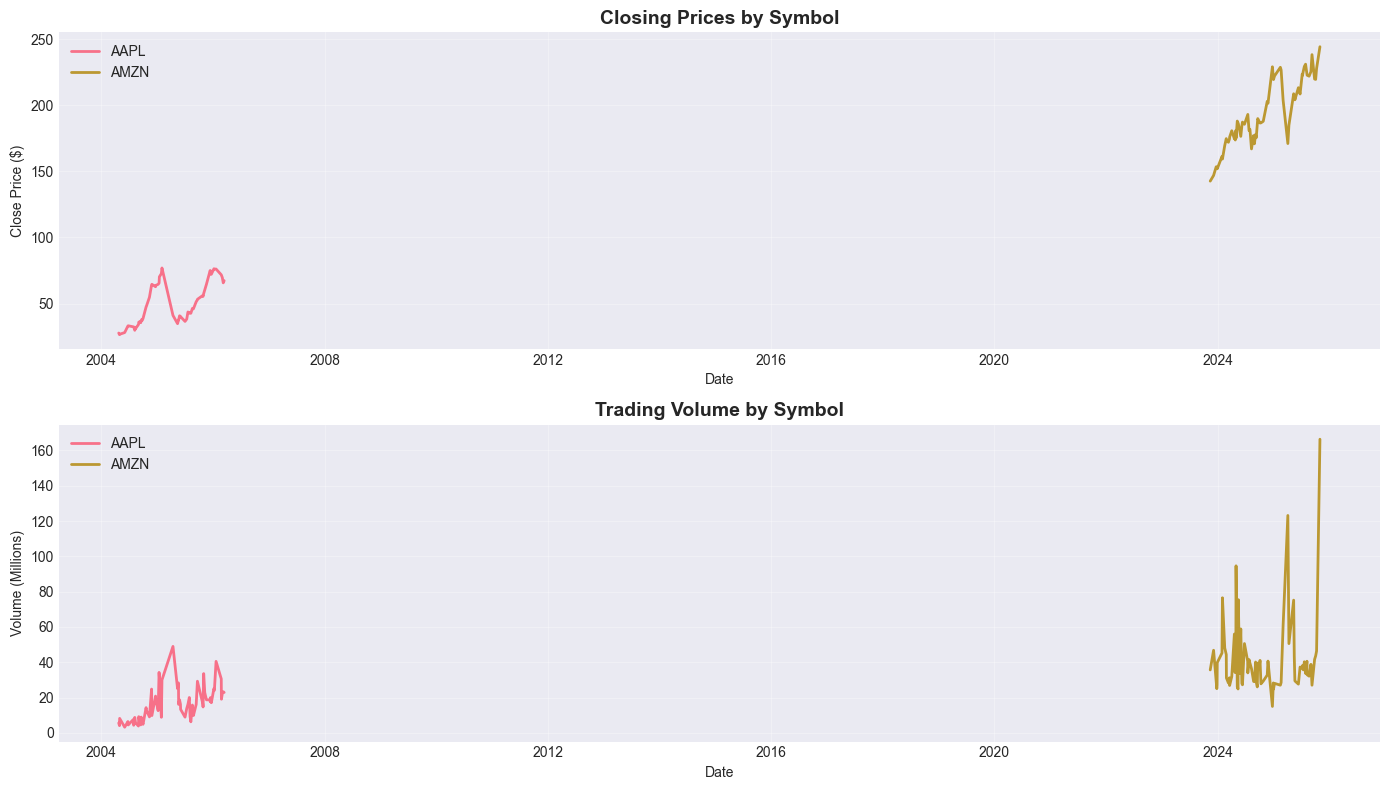

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

for symbol in stocks['symbol'].unique():
    symbol_data = stocks[stocks['symbol'] == symbol].sort_values('date')
    axes[0].plot(symbol_data['date'], symbol_data['close_price'], label=symbol, linewidth=2)

axes[0].set_title('Closing Prices by Symbol', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Close Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

for symbol in stocks['symbol'].unique():
    symbol_data = stocks[stocks['symbol'] == symbol].sort_values('date')
    axes[1].plot(symbol_data['date'], symbol_data['volume']/1e6, label=symbol, linewidth=2)

axes[1].set_title('Trading Volume by Symbol', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume (Millions)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
summary_stats = stocks.groupby('symbol').agg({
    'close_price': ['mean', 'std', 'min', 'max'],
    'volume': ['mean', 'sum']
}).round(2)

summary_stats.columns = ['Avg Price', 'Price StdDev', 'Min Price', 'Max Price', 'Avg Volume', 'Total Volume']
print("\nStock Summary Statistics:")
display(summary_stats)


Stock Summary Statistics:


,Avg Price,Price StdDev,Min Price,Max Price,Avg Volume,Total Volume
symbol,,,,,,
AAPL,49.21,16.81,25.78,90.13,18581314.40,9290657200
AMZN,194.52,25.89,139.74,254.00,43267720.64,21633860318


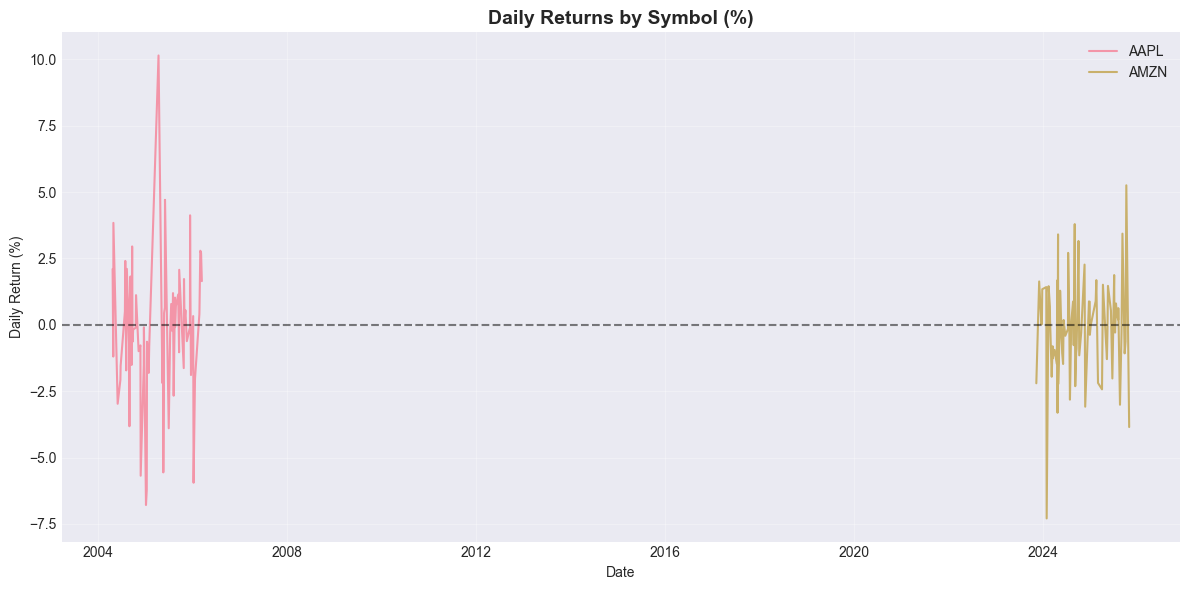


Volatility (Daily Return StdDev %):


symbol
AAPL    5.073494
AMZN    1.955372
Name: daily_return, dtype: float64

In [21]:
stocks['daily_return'] = stocks.groupby('symbol')['close_price'].pct_change()

fig, ax = plt.subplots(figsize=(12, 6))
for symbol in stocks['symbol'].unique():
    symbol_data = stocks[stocks['symbol'] == symbol].sort_values('date')
    ax.plot(symbol_data['date'], symbol_data['daily_return'] * 100, label=symbol, alpha=0.7)

ax.set_title('Daily Returns by Symbol (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Return (%)')
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

volatility = stocks.groupby('symbol')['daily_return'].std() * 100
print("\nVolatility (Daily Return StdDev %):")
display(volatility.sort_values(ascending=False))

### 2.4 Rolling Statistics & Technical Indicators

Calculate moving averages and identify trends.

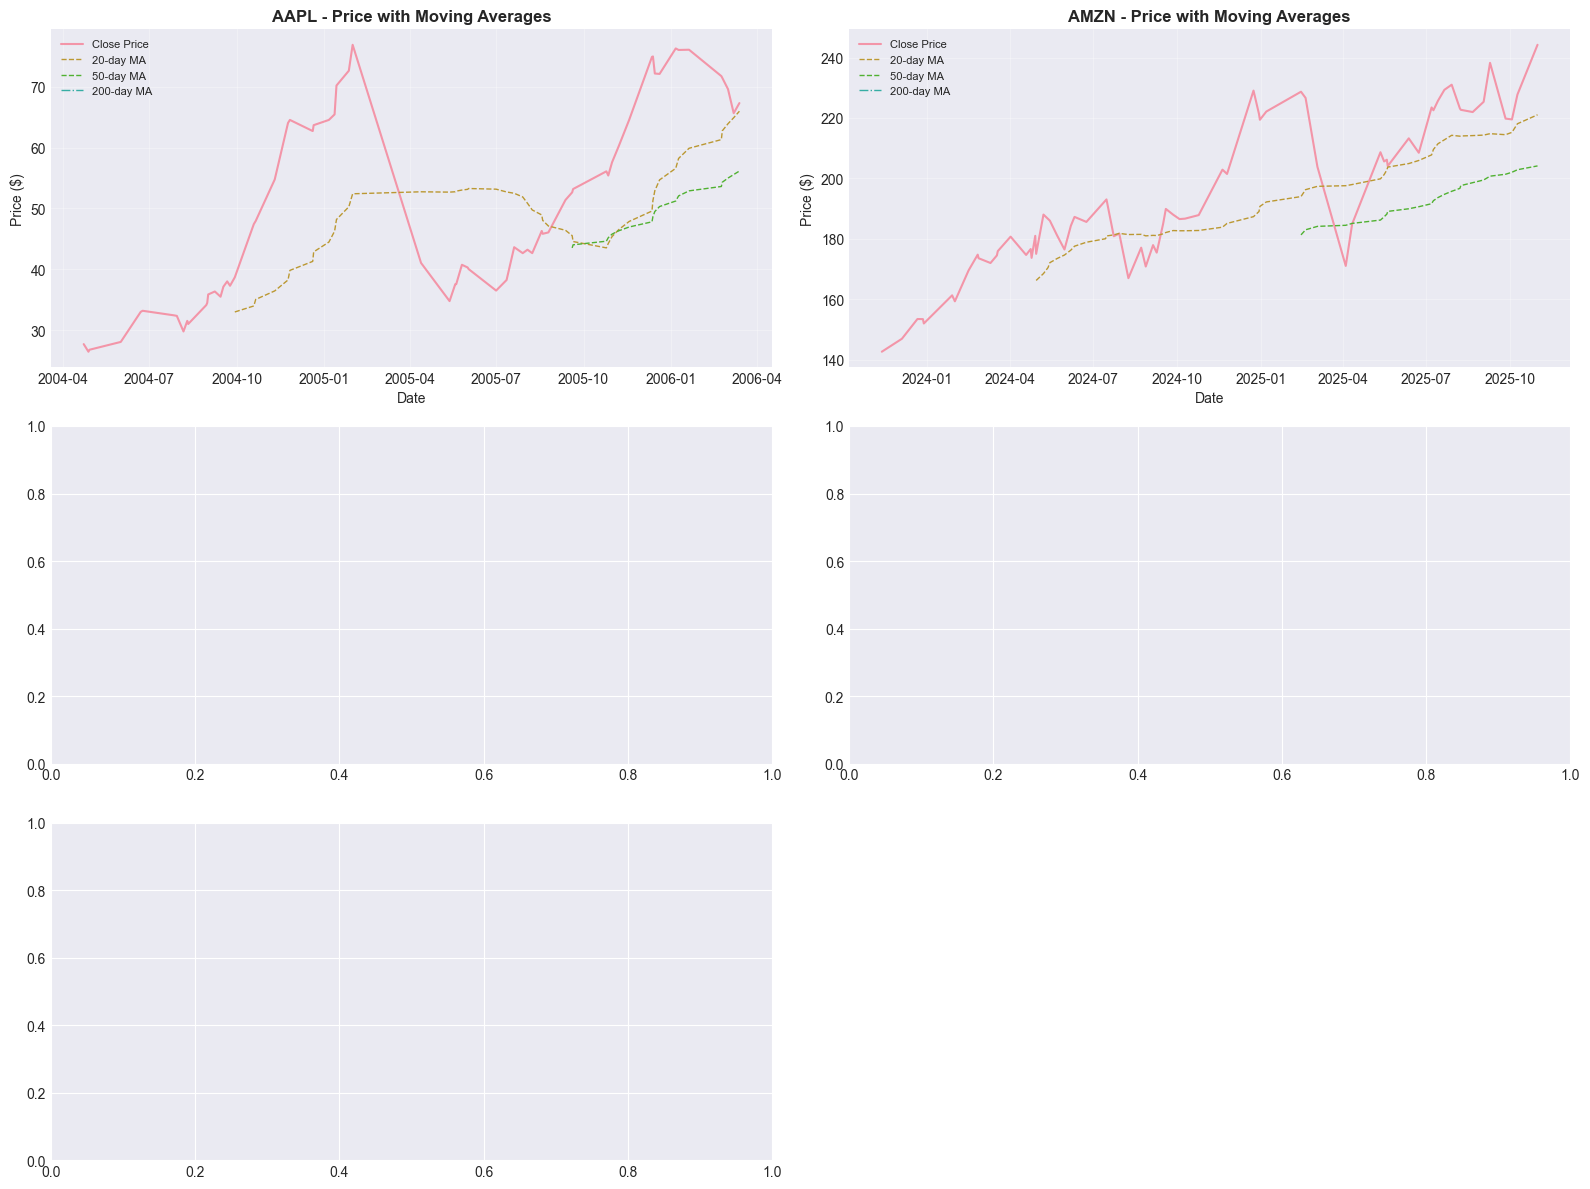

In [23]:
# Calculate moving averages for each symbol
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, symbol in enumerate(stocks['symbol'].unique()):
    symbol_data = stocks[stocks['symbol'] == symbol].sort_values('date').copy()
    
    # Calculate moving averages
    symbol_data['MA_20'] = symbol_data['close_price'].rolling(window=20).mean()
    symbol_data['MA_50'] = symbol_data['close_price'].rolling(window=50).mean()
    symbol_data['MA_200'] = symbol_data['close_price'].rolling(window=200).mean()
    
    # Plot
    axes[idx].plot(symbol_data['date'], symbol_data['close_price'], label='Close Price', linewidth=1.5, alpha=0.7)
    axes[idx].plot(symbol_data['date'], symbol_data['MA_20'], label='20-day MA', linewidth=1, linestyle='--')
    axes[idx].plot(symbol_data['date'], symbol_data['MA_50'], label='50-day MA', linewidth=1, linestyle='--')
    axes[idx].plot(symbol_data['date'], symbol_data['MA_200'], label='200-day MA', linewidth=1, linestyle='-.')
    
    axes[idx].set_title(f'{symbol} - Price with Moving Averages', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Price ($)')
    axes[idx].legend(loc='best', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

axes[5].axis('off')  # Hide the last subplot
plt.tight_layout()
plt.show()

## 3. News Sentiment Analysis

Distribution of sentiment scores across news sources and time.

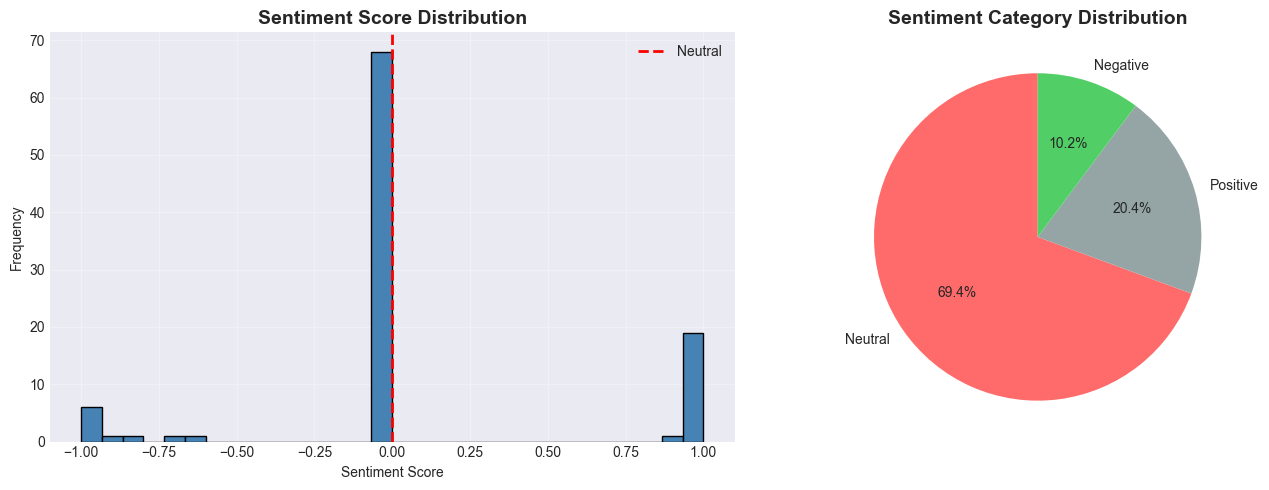


Sentiment Statistics:
Average sentiment: 0.110
Positive articles: 20
Neutral articles: 68
Negative articles: 10


In [22]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(news['sentiment_score'], bins=30, color='steelblue', edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[0].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

sentiment_labels = pd.cut(news['sentiment_score'], 
                          bins=[-1, -0.05, 0.05, 1], 
                          labels=['Negative', 'Neutral', 'Positive'])
sentiment_counts = sentiment_labels.value_counts()

axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', 
           colors=['#ff6b6b', '#95a5a6', '#51cf66'], startangle=90)
axes[1].set_title('Sentiment Category Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nSentiment Statistics:")
print(f"Average sentiment: {news['sentiment_score'].mean():.3f}")
print(f"Positive articles: {(news['sentiment_score'] > 0.05).sum()}")
print(f"Neutral articles: {((news['sentiment_score'] >= -0.05) & (news['sentiment_score'] <= 0.05)).sum()}")
print(f"Negative articles: {(news['sentiment_score'] < -0.05).sum()}")

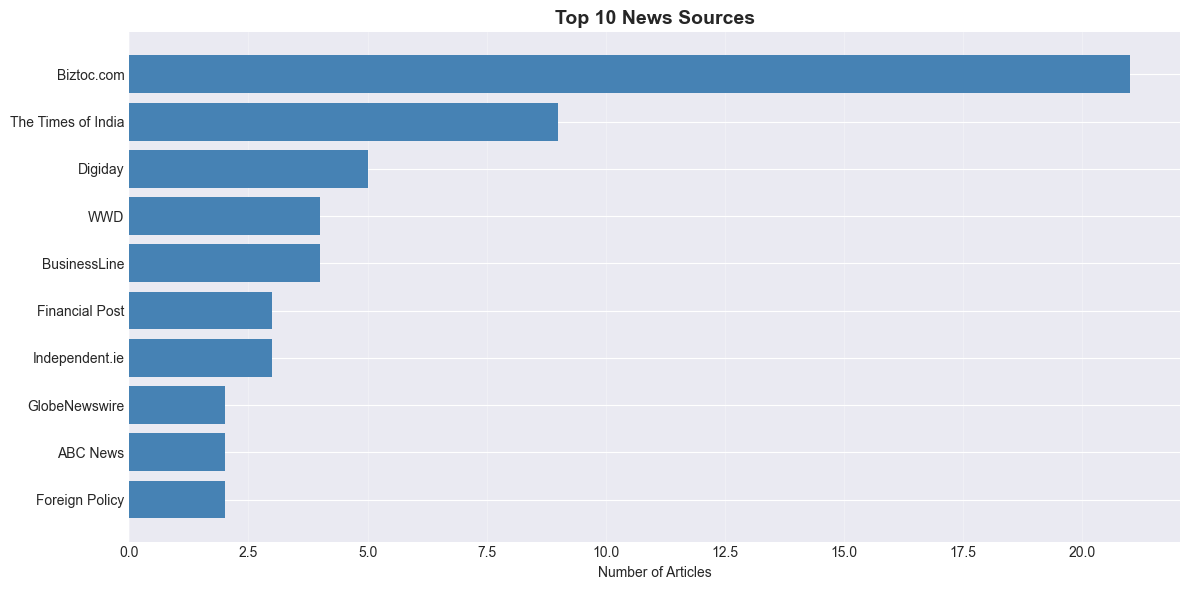

In [9]:
top_sources = news['source_name'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_sources)), top_sources.values, color='steelblue')
plt.yticks(range(len(top_sources)), top_sources.index)
plt.xlabel('Number of Articles')
plt.title('Top 10 News Sources', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

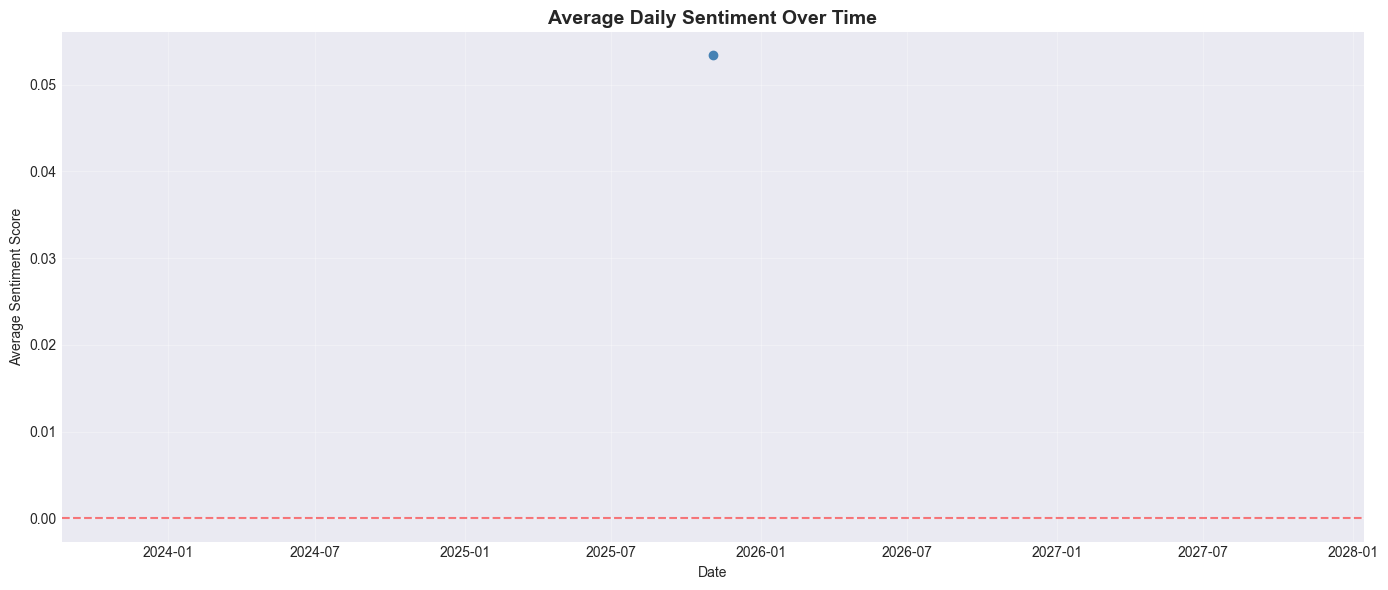

In [10]:
daily_sentiment = news.groupby('date')['sentiment_score'].agg(['mean', 'count']).reset_index()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_sentiment['date'], daily_sentiment['mean'], marker='o', linewidth=2, color='steelblue')
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_title('Average Daily Sentiment Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Sentiment Score')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 3.3 Sentiment Quality Analysis

Evaluate FinBERT sentiment distribution and confidence scores.

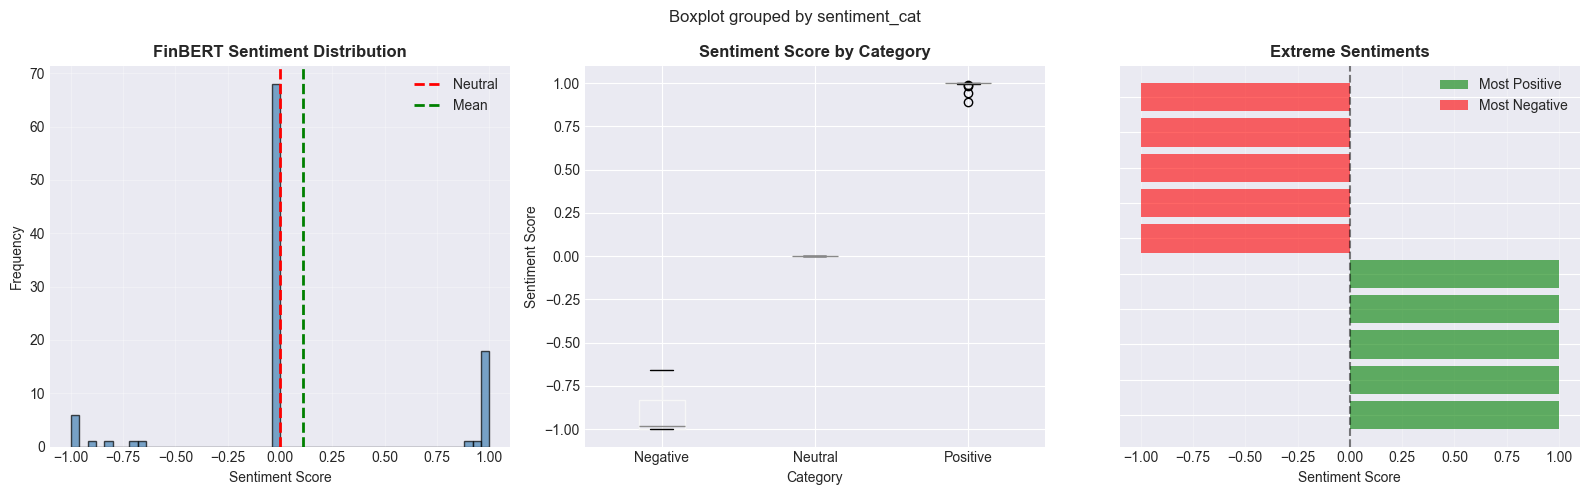


📊 Top 5 Most Positive Headlines:
  [1.000] Rising demand boosts cardamom sector as harvest gains pace in Idukki...
  [1.000] Bajaj Auto sales up 8% YoY in October...
  [1.000] Macquarie tips 40%+ upside for this ASX mining stock...
  [1.000] Merz Aesthetics® Introduces New BELOTERO® Syringe Offering Greater Precision, Co...
  [1.000] Tata Consumer Products Q2 Results: Cons PAT rises 11% YoY to Rs 404 crore; reven...

📊 Top 5 Most Negative Headlines:
  [-1.000] White-collar hiring dips 9% in October as festive holidays slow recruitment...
  [-1.000] Medicare Advantage: Fraudulent and Misleading Marketing Lures Seniors into Plans...
  [-1.000] FDA's top drug regulator resigns after federal officials probe 'serious concerns...
  [-1.000] With Hurricane Melissa, Capitalism and Climate Chaos Bring Devastation to Jamaic...
  [-0.996] Apple November Event LEAKED: Everything Launching This Month...


In [24]:
# Analyze sentiment distribution and extremes
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Distribution by polarity strength
axes[0].hist(news['sentiment_score'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[0].axvline(x=news['sentiment_score'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('FinBERT Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot by sentiment category
news['sentiment_cat'] = pd.cut(news['sentiment_score'], 
                                bins=[-1.1, -0.3, 0.3, 1.1], 
                                labels=['Negative', 'Neutral', 'Positive'])
news.boxplot(column='sentiment_score', by='sentiment_cat', ax=axes[1])
axes[1].set_title('Sentiment Score by Category', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Sentiment Score')
plt.sca(axes[1])
plt.xticks(rotation=0)

# Top positive and negative headlines
top_positive = news.nlargest(5, 'sentiment_score')[['title', 'sentiment_score']]
top_negative = news.nsmallest(5, 'sentiment_score')[['title', 'sentiment_score']]

axes[2].barh(range(5), top_positive['sentiment_score'].values, color='green', alpha=0.6, label='Most Positive')
axes[2].barh(range(5, 10), top_negative['sentiment_score'].values, color='red', alpha=0.6, label='Most Negative')
axes[2].set_yticks(range(10))
axes[2].set_yticklabels([])
axes[2].set_xlabel('Sentiment Score')
axes[2].set_title('Extreme Sentiments', fontsize=12, fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='--', alpha=0.5)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Top 5 Most Positive Headlines:")
for idx, row in top_positive.iterrows():
    print(f"  [{row['sentiment_score']:.3f}] {row['title'][:80]}...")

print("\n📊 Top 5 Most Negative Headlines:")
for idx, row in top_negative.iterrows():
    print(f"  [{row['sentiment_score']:.3f}] {row['title'][:80]}...")

## 4. Correlation Analysis

Examine relationships between sentiment and stock price movements.

In [25]:
daily_stocks = stocks.groupby(['date', 'symbol'])['close_price'].mean().reset_index()
daily_sentiment_agg = news.groupby('date')['sentiment_score'].mean().reset_index()

merged = daily_stocks.merge(daily_sentiment_agg, on='date', how='inner')

correlation_results = {}
for symbol in merged['symbol'].unique():
    symbol_data = merged[merged['symbol'] == symbol]
    if len(symbol_data) > 1:
        corr = symbol_data['close_price'].corr(symbol_data['sentiment_score'])
        correlation_results[symbol] = corr

print("Correlation between sentiment and closing price:")
for symbol, corr in sorted(correlation_results.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{symbol}: {corr:.3f}")

Correlation between sentiment and closing price:


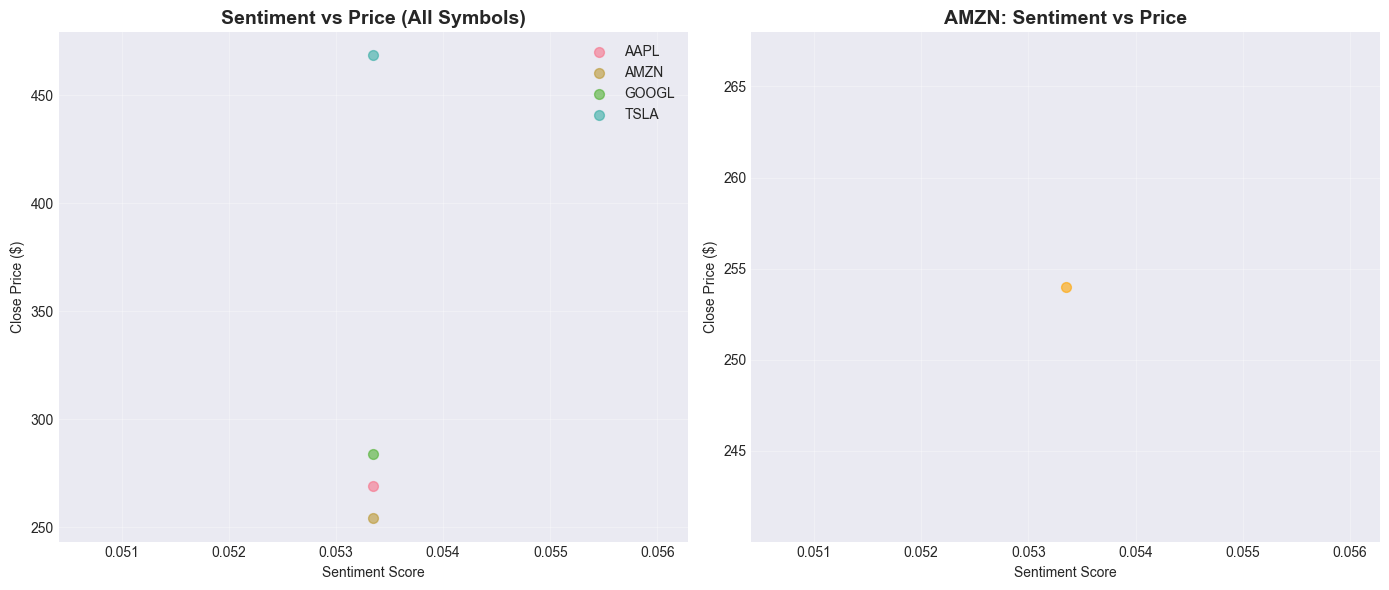

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for symbol in merged['symbol'].unique():
    symbol_data = merged[merged['symbol'] == symbol]
    axes[0].scatter(symbol_data['sentiment_score'], symbol_data['close_price'], 
                   label=symbol, alpha=0.6, s=50)

axes[0].set_title('Sentiment vs Price (All Symbols)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Close Price ($)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

amzn_data = merged[merged['symbol'] == 'AMZN']
if len(amzn_data) > 0:
    axes[1].scatter(amzn_data['sentiment_score'], amzn_data['close_price'], 
                   color='orange', alpha=0.6, s=50)
    z = np.polyfit(amzn_data['sentiment_score'], amzn_data['close_price'], 1)
    p = np.poly1d(z)
    axes[1].plot(amzn_data['sentiment_score'].sort_values(), 
                p(amzn_data['sentiment_score'].sort_values()), 
                "r--", alpha=0.8, linewidth=2)
    
axes[1].set_title('AMZN: Sentiment vs Price', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Close Price ($)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.2 Lead/Lag Analysis

Test if sentiment predicts future price movements (1-3 day lag).

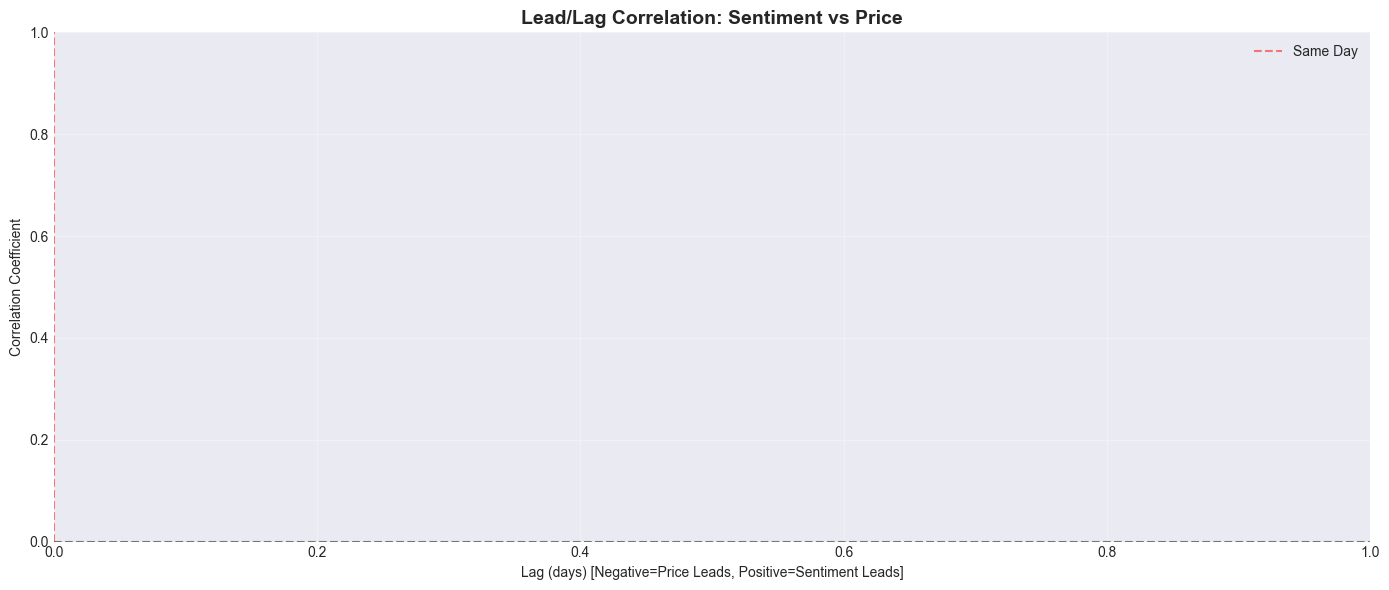


🔍 Best Lead/Lag Correlations:


In [26]:
# Calculate lead/lag correlations
lag_results = {}

for symbol in stocks['symbol'].unique():
    symbol_stocks = stocks[stocks['symbol'] == symbol].copy()
    
    # Merge with sentiment
    merged_symbol = symbol_stocks.merge(
        news.groupby('date')['sentiment_score'].mean().reset_index(),
        on='date',
        how='inner'
    ).sort_values('date')
    
    if len(merged_symbol) < 10:
        continue
    
    # Calculate correlations for different lags
    lags = {}
    for lag in range(-3, 4):  # -3 to +3 days
        if lag == 0:
            corr = merged_symbol['close_price'].corr(merged_symbol['sentiment_score'])
        elif lag > 0:
            # Positive lag: sentiment LEADS price
            corr = merged_symbol['close_price'].shift(-lag).corr(merged_symbol['sentiment_score'])
        else:
            # Negative lag: sentiment LAGS price
            corr = merged_symbol['close_price'].corr(merged_symbol['sentiment_score'].shift(lag))
        lags[lag] = corr
    
    lag_results[symbol] = lags

# Plot lead/lag correlations
fig, ax = plt.subplots(figsize=(14, 6))

for symbol, lags in lag_results.items():
    lag_days = sorted(lags.keys())
    correlations = [lags[day] for day in lag_days]
    ax.plot(lag_days, correlations, marker='o', label=symbol, linewidth=2)

ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Same Day')
ax.set_title('Lead/Lag Correlation: Sentiment vs Price', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag (days) [Negative=Price Leads, Positive=Sentiment Leads]')
ax.set_ylabel('Correlation Coefficient')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best lag for each symbol
print("\n🔍 Best Lead/Lag Correlations:")
for symbol, lags in lag_results.items():
    best_lag = max(lags.items(), key=lambda x: abs(x[1]))
    direction = "Sentiment LEADS price" if best_lag[0] > 0 else "Price LEADS sentiment" if best_lag[0] < 0 else "Same day"
    print(f"  {symbol}: {best_lag[1]:.3f} at {abs(best_lag[0])} day(s) - {direction}")

### 4.3 Volatility vs Sentiment

Analyze if negative sentiment correlates with increased volatility.

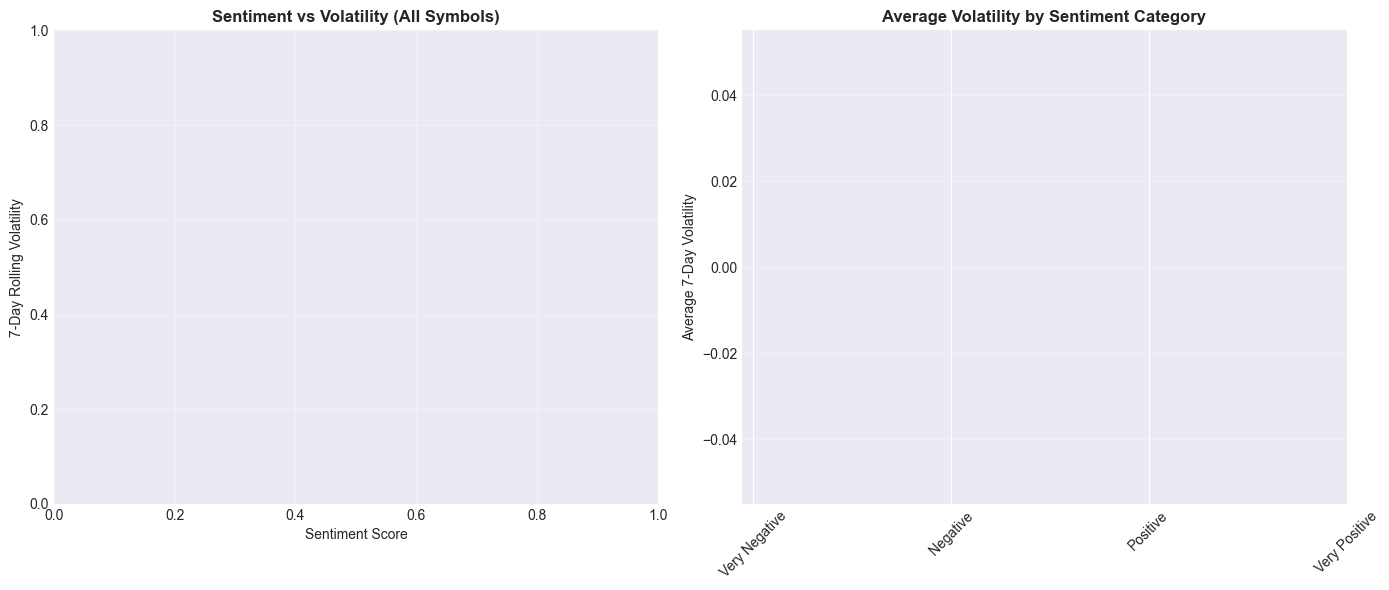


📈 Overall Correlation (Volatility vs Sentiment): nan


In [27]:
# Calculate rolling volatility and merge with sentiment
volatility_analysis = []

for symbol in stocks['symbol'].unique():
    symbol_data = stocks[stocks['symbol'] == symbol].sort_values('date').copy()
    
    # Calculate 7-day rolling volatility
    symbol_data['rolling_volatility'] = symbol_data['daily_return'].rolling(window=7).std()
    
    # Merge with sentiment
    merged_vol = symbol_data.merge(
        news.groupby('date')['sentiment_score'].mean().reset_index(),
        on='date',
        how='inner'
    )
    
    volatility_analysis.append(merged_vol[['symbol', 'date', 'rolling_volatility', 'sentiment_score']])

vol_df = pd.concat(volatility_analysis, ignore_index=True)

# Plot volatility vs sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot
for symbol in vol_df['symbol'].unique():
    symbol_vol = vol_df[vol_df['symbol'] == symbol]
    axes[0].scatter(symbol_vol['sentiment_score'], symbol_vol['rolling_volatility'], 
                   label=symbol, alpha=0.6, s=30)

axes[0].set_title('Sentiment vs Volatility (All Symbols)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('7-Day Rolling Volatility')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Binned analysis
vol_df['sentiment_bin'] = pd.cut(vol_df['sentiment_score'], 
                                 bins=[-1.1, -0.5, 0, 0.5, 1.1], 
                                 labels=['Very Negative', 'Negative', 'Positive', 'Very Positive'])
binned_vol = vol_df.groupby('sentiment_bin')['rolling_volatility'].mean()

axes[1].bar(range(len(binned_vol)), binned_vol.values, color=['red', 'orange', 'lightgreen', 'green'])
axes[1].set_xticks(range(len(binned_vol)))
axes[1].set_xticklabels(binned_vol.index, rotation=45)
axes[1].set_title('Average Volatility by Sentiment Category', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average 7-Day Volatility')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate correlation
corr_vol_sent = vol_df['rolling_volatility'].corr(vol_df['sentiment_score'])
print(f"\n📈 Overall Correlation (Volatility vs Sentiment): {corr_vol_sent:.3f}")

## 5. Key Insights Summary

Based on the analysis above, document key findings and patterns.

In [28]:
print("=" * 60)
print("KEY INSIGHTS SUMMARY")
print("=" * 60)

print(f"\n1. DATA VOLUME:")
print(f"   - Stock records analyzed: {len(stocks)}")
print(f"   - Symbols tracked: {stocks['symbol'].nunique()}")
print(f"   - News articles: {len(news)}")
print(f"   - Date range: {stocks['date'].min().date()} to {stocks['date'].max().date()}")

print(f"\n2. STOCK PERFORMANCE:")
most_volatile = volatility.idxmax()
least_volatile = volatility.idxmin()
print(f"   - Most volatile: {most_volatile} ({volatility[most_volatile]:.2f}%)")
print(f"   - Least volatile: {least_volatile} ({volatility[least_volatile]:.2f}%)")

print(f"\n3. SENTIMENT ANALYSIS:")
avg_sentiment = news['sentiment_score'].mean()
sentiment_bias = "Positive" if avg_sentiment > 0.05 else "Negative" if avg_sentiment < -0.05 else "Neutral"
print(f"   - Average sentiment: {avg_sentiment:.3f} ({sentiment_bias})")
print(f"   - Most covered source: {news['source_name'].value_counts().index[0]}")

print(f"\n4. CORRELATIONS:")
if correlation_results:
    strongest = max(correlation_results.items(), key=lambda x: abs(x[1]))
    print(f"   - Strongest sentiment-price correlation: {strongest[0]} ({strongest[1]:.3f})")

print("\n" + "=" * 60)

KEY INSIGHTS SUMMARY

1. DATA VOLUME:
   - Stock records analyzed: 1000
   - Symbols tracked: 2
   - News articles: 98
   - Date range: 2004-04-23 to 2025-10-31

2. STOCK PERFORMANCE:
   - Most volatile: AAPL (5.07%)
   - Least volatile: AMZN (1.96%)

3. SENTIMENT ANALYSIS:
   - Average sentiment: 0.110 (Positive)
   - Most covered source: Biztoc.com

4. CORRELATIONS:



## Next Steps

**Backend Development:**
1. Build FastAPI/Flask REST API to serve data from Supabase
2. Endpoints: `/stocks/{symbol}`, `/news/sentiment`, `/correlations`
3. Add data aggregation and filtering logic

**Frontend Options:**
- **React Dashboard** (Recommended for portfolio):
  - Libraries: Recharts, Plotly.js, or Apache ECharts
  - Real-time updates with WebSocket/polling
  - Custom UI/UX with full design control
  - Professional, production-ready
  
- **Streamlit** (Quick prototype):
  - Faster development
  - Limited customization
  - Good for internal tools

**Advanced Features:**
1. Time series forecasting (ARIMA, Prophet, LSTM)
2. Real-time data ingestion pipeline
3. Anomaly detection for unusual price movements
4. Portfolio optimization and risk analysis